Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best classification performance measures for the features (10-fold CV, Grid Search).
----------------------------------------------------------------------------------------------------
Classifier      Class    PPV        NPV        Sensitivity     Specificity     Accuracy  
----------------------------------------------------------------------------------------------------
SVM             DM       0.9363      0.9620      0.9631           0.9344           0.9488
SVM             CG       0.9620      0.9363      0.9344           0.9631          


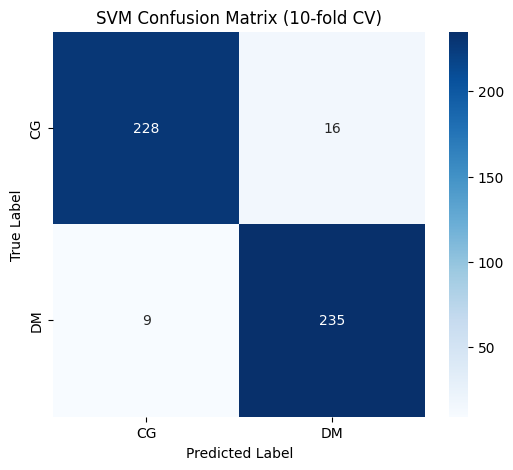

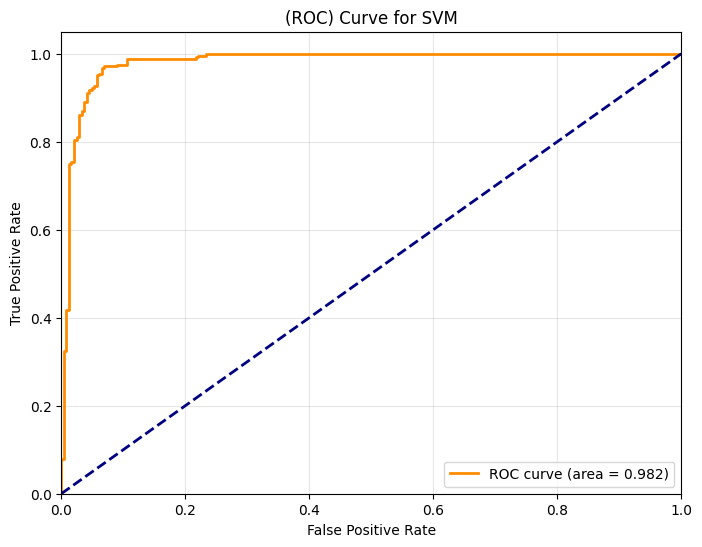

Area Under the ROC Curve (AUC): 0.9816


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
csv_path = "/content/balanced_dataset_FULL_FOOT_SIFT_2.xlsx"  # Update with your file path
df = pd.read_excel(csv_path)

# Ensure dataset has labels
if "label" not in df.columns:
    raise ValueError("Dataset must have a 'label' column for classification.")

# Separate features and labels
X = df.drop(columns=["label"])
y = df["label"].astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define SVM and parameter grid for Grid Search
svm = SVC(probability=True)
param_grid = {
    'C': [0.1, 1, 10],           # Regularization parameter
    'kernel': ['linear', 'rbf'], # Kernel type
    'gamma': ['scale', 'auto']   # Kernel coefficient for 'rbf'
}

# 10-fold stratified cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Use accuracy as the scoring metric
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
grid_search.fit(X_scaled, y)

# Best estimator from grid search
best_svm = grid_search.best_estimator_

# Cross-validated predictions (for metrics)
y_pred = cross_val_predict(best_svm, X_scaled, y, cv=cv)

# Get probability predictions for ROC curve
y_prob = cross_val_predict(best_svm, X_scaled, y, cv=cv, method='predict_proba')[:, 1]

# Confusion matrix and metrics
conf_matrix = confusion_matrix(y, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
accuracy = accuracy_score(y, y_pred)

# Metrics for DM (class 1)
ppv_dm = tp / (tp + fp) if (tp + fp) > 0 else 0
npv_dm = tn / (tn + fn) if (tn + fn) > 0 else 0
sensitivity_dm = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity_dm = tn / (tn + fp) if (tn + fp) > 0 else 0

# Metrics for CG (class 0)
ppv_cg = tn / (tn + fn) if (tn + fn) > 0 else 0
npv_cg = tp / (tp + fp) if (tp + fp) > 0 else 0
sensitivity_cg = tn / (tn + fp) if (tn + fp) > 0 else 0
specificity_cg = tp / (tp + fn) if (tp + fn) > 0 else 0

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)

# Print results in tabular format
print("Best classification performance measures for the features (10-fold CV, Grid Search).")
print("-" * 100)
print(f"{'Classifier':<15} {'Class':<8} {'PPV':<10} {'NPV':<10} {'Sensitivity':<15} {'Specificity':<15} {'Accuracy':<10}")
print("-" * 100)
print(f"{'SVM':<15} {'DM':<8} {ppv_dm:.4f}{'':<5} {npv_dm:.4f}{'':<5} {sensitivity_dm:.4f}{'':<10} {specificity_dm:.4f}{'':<10} {accuracy:.4f}")
print(f"{'SVM':<15} {'CG':<8} {ppv_cg:.4f}{'':<5} {npv_cg:.4f}{'':<5} {sensitivity_cg:.4f}{'':<10} {specificity_cg:.4f}{'':<10}")

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["CG", "DM"], yticklabels=["CG", "DM"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("SVM Confusion Matrix (10-fold CV)")
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for SVM')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Area Under the ROC Curve (AUC): {roc_auc:.4f}")



XGBoost


Best classification performance measures for the SURF features.
----------------------------------------------------------------------------------------------------
Classifier      Class    PPV        NPV        Sensitivity     Specificity     Accuracy  
----------------------------------------------------------------------------------------------------
XGBoost         DM       0.8936      0.8627      0.8571           0.8980           0.8776
XGBoost         CG       0.8627      0.8936      0.8980           0.8571          


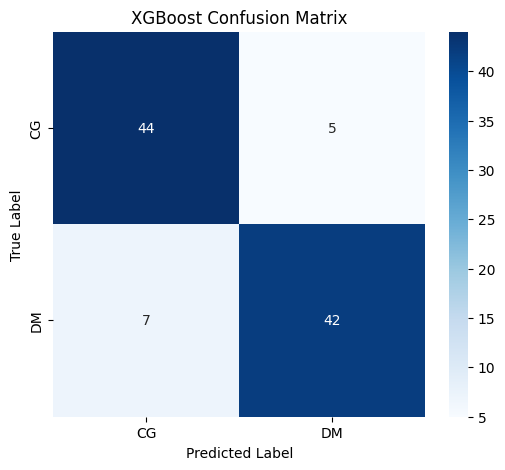

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Load the CSV file containing features
csv_path = "/content/balanced_dataset_FULL_FOOT_SIFT_2.xlsx"  # Update with your file path
df = pd.read_excel(csv_path)

# Ensure dataset has labels
if "label" not in df.columns:
    raise ValueError("Dataset must have a 'label' column for classification.")

# Separate features and labels
X = df.drop(columns=["label"]).values  # Convert to numpy array
y = df["label"].astype(int).values     # Convert to numpy array

# Standardize features to improve model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the XGBoost classifier
xgb = XGBClassifier(n_estimators=10, max_depth=1, learning_rate=0.5, random_state=42)
xgb.fit(X_train, y_train)

# Predict on test data
y_pred = xgb.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract values from confusion matrix
# For binary classification, confusion matrix is in the form:
# [[TN, FP], [FN, TP]]
if cm.shape == (2, 2):  # Ensure proper shape
    TN, FP, FN, TP = cm.ravel()

    # Calculate metrics for both classes
    # Class 1 (DM) metrics
    ppv_dm = TP / (TP + FP) if (TP + FP) > 0 else 0  # PPV (Precision) for DM
    npv_dm = TN / (TN + FN) if (TN + FN) > 0 else 0  # NPV for DM
    sensitivity_dm = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity for DM
    specificity_dm = TN / (TN + FP) if (TN + FP) > 0 else 0  # Specificity for DM

    # Class 0 (CG) metrics
    ppv_cg = TN / (TN + FN) if (TN + FN) > 0 else 0  # PPV for CG
    npv_cg = TP / (TP + FP) if (TP + FP) > 0 else 0  # NPV for CG
    sensitivity_cg = TN / (TN + FP) if (TN + FP) > 0 else 0  # Sensitivity for CG
    specificity_cg = TP / (TP + FN) if (TP + FN) > 0 else 0  # Specificity for CG

    # Overall accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print results in tabular format similar to the image
    print("Best classification performance measures for the SURF features.")
    print("-" * 100)
    print(f"{'Classifier':<15} {'Class':<8} {'PPV':<10} {'NPV':<10} {'Sensitivity':<15} {'Specificity':<15} {'Accuracy':<10}")
    print("-" * 100)
    print(f"{'XGBoost':<15} {'DM':<8} {ppv_dm:.4f}{'':<5} {npv_dm:.4f}{'':<5} {sensitivity_dm:.4f}{'':<10} {specificity_dm:.4f}{'':<10} {accuracy:.4f}")
    print(f"{'XGBoost':<15} {'CG':<8} {ppv_cg:.4f}{'':<5} {npv_cg:.4f}{'':<5} {sensitivity_cg:.4f}{'':<10} {specificity_cg:.4f}{'':<10}")

    # Visualize confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["CG", "DM"], yticklabels=["CG", "DM"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("XGBoost Confusion Matrix")
    plt.show()
else:
    print("Error: Confusion matrix does not have the expected shape for binary classification.")


KNN

Best classification performance measures for the features.
----------------------------------------------------------------------------------------------------
Classifier      Class    PPV        NPV        Sensitivity     Specificity     Accuracy  
----------------------------------------------------------------------------------------------------
KNN             DM       0.8276      0.9750      0.9796           0.7959           0.8878
KNN             CG       0.9750      0.8276      0.7959           0.9796          


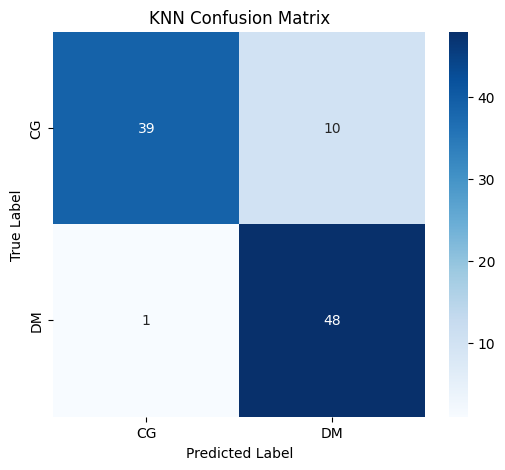

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file containing features
csv_path = "/content/balanced_dataset_FULL_FOOT_SIFT_2.xlsx"  # Update with your file path
df = pd.read_excel(csv_path)

# Ensure dataset has labels
if "label" not in df.columns:
    raise ValueError("Dataset must have a 'label' column for classification.")

# Separate features and labels
X = df.drop(columns=["label"])  # Feature vectors
y = df["label"]  # Class labels

# Convert boolean labels to numerical (False → 0 for CG, True → 1 for DM)
y = y.astype(int)

# Standardize features to improve KNN performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train a KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn.fit(X_train, y_train)

# Predict on test data
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate metrics for DM (class 1)
ppv_dm = tp / (tp + fp) if (tp + fp) > 0 else 0
npv_dm = tn / (tn + fn) if (tn + fn) > 0 else 0
sensitivity_dm = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity_dm = tn / (tn + fp) if (tn + fp) > 0 else 0

# Calculate metrics for CG (class 0)
ppv_cg = tn / (tn + fn) if (tn + fn) > 0 else 0
npv_cg = tp / (tp + fp) if (tp + fp) > 0 else 0
sensitivity_cg = tn / (tn + fp) if (tn + fp) > 0 else 0
specificity_cg = tp / (tp + fn) if (tp + fn) > 0 else 0

# Print results in tabular format similar to the reference image
print("Best classification performance measures for the features.")
print("-" * 100)
print(f"{'Classifier':<15} {'Class':<8} {'PPV':<10} {'NPV':<10} {'Sensitivity':<15} {'Specificity':<15} {'Accuracy':<10}")
print("-" * 100)
print(f"{'KNN':<15} {'DM':<8} {ppv_dm:.4f}{'':<5} {npv_dm:.4f}{'':<5} {sensitivity_dm:.4f}{'':<10} {specificity_dm:.4f}{'':<10} {accuracy:.4f}")
print(f"{'KNN':<15} {'CG':<8} {ppv_cg:.4f}{'':<5} {npv_cg:.4f}{'':<5} {sensitivity_cg:.4f}{'':<10} {specificity_cg:.4f}{'':<10}")

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["CG", "DM"], yticklabels=["CG", "DM"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("KNN Confusion Matrix")
plt.show()


RF

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Function to calculate metrics
def evaluate_metrics(y_test, y_pred):
    """
    Calculate PPV, NPV, sensitivity, specificity for both classes.
    """
    cm = confusion_matrix(y_test, y_pred)

    # Ensure we have a 2x2 confusion matrix for binary classification
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()

        # Metrics for DM (class 1)
        ppv_dm = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv_dm = tn / (tn + fn) if (tn + fn) > 0 else 0
        sensitivity_dm = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity_dm = tn / (tn + fp) if (tn + fp) > 0 else 0

        # Metrics for CG (class 0)
        ppv_cg = tn / (tn + fn) if (tn + fn) > 0 else 0
        npv_cg = tp / (tp + fp) if (tp + fp) > 0 else 0
        sensitivity_cg = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_cg = tp / (tp + fn) if (tp + fn) > 0 else 0

        # Overall accuracy
        accuracy = accuracy_score(y_test, y_pred)

        metrics = {
            "DM": {
                "PPV": round(ppv_dm, 4),
                "NPV": round(npv_dm, 4),
                "Sensitivity": round(sensitivity_dm, 4),
                "Specificity": round(specificity_dm, 4),
            },
            "CG": {
                "PPV": round(ppv_cg, 4),
                "NPV": round(npv_cg, 4),
                "Sensitivity": round(sensitivity_cg, 4),
                "Specificity": round(specificity_cg, 4),
            },
            "Accuracy": round(accuracy, 4)
        }
    else:
        metrics = {"Error": "Not a binary classification result"}

    return cm, metrics

# Random Forest Classifier Implementation
def random_forest_classifier(input_file):
    """
    Classify data using Random Forest and evaluate performance metrics.

    Args:
        input_file (str): Path to the Excel file containing descriptors and labels.
    """
    # Load the dataset
    df = pd.read_excel(input_file)

    # Extract features and labels
    X = df.iloc[:, :-1].values   # All descriptor columns except the label column
    y = df['label'].values       # Label column

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    # Train Random Forest classifier
    # Modify these parameters to reduce model complexity
    model = RandomForestClassifier(
        n_estimators=10,           # Reduce from 100 to 10 trees
        max_depth=3,               # Limit tree depth significantly
        min_samples_split=5,       # Require more samples before splitting
        min_samples_leaf=4,        # Require more samples in leaf nodes
        max_features='sqrt',       # Use only sqrt(n_features) for each split
        bootstrap=True,
        random_state=42            # Try different random seeds if needed
    )

    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate metrics
    cm, metrics = evaluate_metrics(y_test, y_pred)

    # Print confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Print metrics in a formatted table like the image reference
    print("\nBest classification performance measures for the features.")
    print("-" * 100)
    print(f"{'Classifier':<15} {'Class':<8} {'PPV':<10} {'NPV':<10} {'Sensitivity':<15} {'Specificity':<15} {'Accuracy':<10}")
    print("-" * 100)

    # Print DM metrics
    print(f"{'RF':<15} {'DM':<8} {metrics['DM']['PPV']:.4f}{'':<5} "
          f"{metrics['DM']['NPV']:.4f}{'':<5} {metrics['DM']['Sensitivity']:.4f}{'':<10} "
          f"{metrics['DM']['Specificity']:.4f}{'':<10} {metrics['Accuracy']:.4f}")

    # Print CG metrics
    print(f"{'RF':<15} {'CG':<8} {metrics['CG']['PPV']:.4f}{'':<5} "
          f"{metrics['CG']['NPV']:.4f}{'':<5} {metrics['CG']['Sensitivity']:.4f}{'':<10} "
          f"{metrics['CG']['Specificity']:.4f}{'':<10}")

# Example usage
input_file = '/content/balanced_dataset_FULL_FOOT_SIFT_2.xlsx'   # Replace with your dataset file path
random_forest_classifier(input_file)


Confusion Matrix:
[[86 17]
 [ 9 84]]

Best classification performance measures for the features.
----------------------------------------------------------------------------------------------------
Classifier      Class    PPV        NPV        Sensitivity     Specificity     Accuracy  
----------------------------------------------------------------------------------------------------
RF              DM       0.8317      0.9053      0.9032           0.8350           0.8673
RF              CG       0.9053      0.8317      0.8350           0.9032          


DT

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Function to calculate metrics
def evaluate_metrics(y_test, y_pred):
    """
    Calculate PPV, NPV, sensitivity, specificity for both classes.
    """
    cm = confusion_matrix(y_test, y_pred)

    # Ensure we have a 2x2 confusion matrix for binary classification
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()

        # Metrics for DM (class 1)
        ppv_dm = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv_dm = tn / (tn + fn) if (tn + fn) > 0 else 0
        sensitivity_dm = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity_dm = tn / (tn + fp) if (tn + fp) > 0 else 0

        # Metrics for CG (class 0)
        ppv_cg = tn / (tn + fn) if (tn + fn) > 0 else 0
        npv_cg = tp / (tp + fp) if (tp + fp) > 0 else 0
        sensitivity_cg = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_cg = tp / (tp + fn) if (tp + fn) > 0 else 0

        # Overall accuracy
        accuracy = accuracy_score(y_test, y_pred)

        metrics = {
            "DM": {
                "PPV": round(ppv_dm, 4),
                "NPV": round(npv_dm, 4),
                "Sensitivity": round(sensitivity_dm, 4),
                "Specificity": round(specificity_dm, 4),
            },
            "CG": {
                "PPV": round(ppv_cg, 4),
                "NPV": round(npv_cg, 4),
                "Sensitivity": round(sensitivity_cg, 4),
                "Specificity": round(specificity_cg, 4),
            },
            "Accuracy": round(accuracy, 4)
        }
    else:
        metrics = {"Error": "Not a binary classification result"}

    return cm, metrics

# Decision Tree Classifier Implementation
def decision_tree_classifier(input_file):
    """
    Classify data using Decision Tree and evaluate performance metrics.

    Args:
        input_file (str): Path to the Excel file containing descriptors and labels.
    """
    # Load the dataset
    df = pd.read_excel(input_file)

    # Extract features and labels
    X = df.iloc[:, :-1].values   # All descriptor columns except the label column
    y = df['label'].values       # Label column

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train Decision Tree classifier with constrained depth to reduce overfitting
    model = DecisionTreeClassifier(max_depth=3, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate metrics
    cm, metrics = evaluate_metrics(y_test, y_pred)

    # Print confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Print metrics in a formatted table like the image reference
    print("\nBest classification performance measures for the features.")
    print("-" * 100)
    print(f"{'Classifier':<15} {'Class':<8} {'PPV':<10} {'NPV':<10} {'Sensitivity':<15} {'Specificity':<15} {'Accuracy':<10}")
    print("-" * 100)

    # Print DM metrics
    print(f"{'DT':<15} {'DM':<8} {metrics['DM']['PPV']:.4f}{'':<5} "
          f"{metrics['DM']['NPV']:.4f}{'':<5} {metrics['DM']['Sensitivity']:.4f}{'':<10} "
          f"{metrics['DM']['Specificity']:.4f}{'':<10} {metrics['Accuracy']:.4f}")

    # Print CG metrics
    print(f"{'DT':<15} {'CG':<8} {metrics['CG']['PPV']:.4f}{'':<5} "
          f"{metrics['CG']['NPV']:.4f}{'':<5} {metrics['CG']['Sensitivity']:.4f}{'':<10} "
          f"{metrics['CG']['Specificity']:.4f}{'':<10}")

# Example usage
input_file = '/content/balanced_dataset_FULL_FOOT_SIFT_2.xlsx'   # Replace with your dataset file path
decision_tree_classifier(input_file)


Confusion Matrix:
[[71  5]
 [11 60]]

Best classification performance measures for the features.
----------------------------------------------------------------------------------------------------
Classifier      Class    PPV        NPV        Sensitivity     Specificity     Accuracy  
----------------------------------------------------------------------------------------------------
DT              DM       0.9231      0.8659      0.8451           0.9342           0.8912
DT              CG       0.8659      0.9231      0.9342           0.8451          


Best classification performance measures for the features.
----------------------------------------------------------------------------------------------------
Classifier      Class    PPV        NPV        Sensitivity     Specificity     Accuracy  
----------------------------------------------------------------------------------------------------
PNN             DM       0.7931      0.9875      0.9892           0.7670           0.8724
PNN             CG       0.9875      0.7931      0.7670           0.9892          


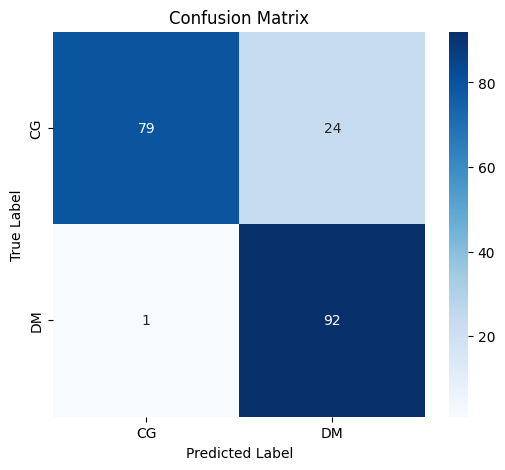

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file containing features
csv_path = "/content/balanced_dataset_FULL_FOOT_SIFT_2.xlsx"  # Update with your file path
df = pd.read_excel(csv_path)

# Ensure dataset has labels
if "label" not in df.columns:
    raise ValueError("Dataset must have a 'label' column for classification.")

# Separate features and labels
X = df.drop(columns=[ "label"])  # Feature vectors
y = df["label"]  # Class labels

# Convert boolean labels to numerical (False → 0 for CG, True → 1 for DM)
y = y.astype(int)

# Standardize features to improve PNN performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

# Simple PNN implementation
def gaussian_kernel(x, center, sigma=2.0):
    """Gaussian kernel for PNN."""
    return np.exp(-np.sum((x - center) ** 2) / (2 * sigma ** 2))

def pnn_predict(X_test, X_train, y_train, sigma=1.0):
    """Predict using PNN."""
    predictions = []
    for x in X_test:
        outputs = []
        for class_label in np.unique(y_train):
            class_data = X_train[y_train == class_label]
            output = np.sum([gaussian_kernel(x, c, sigma) for c in class_data])
            outputs.append(output)
        predictions.append(np.argmax(outputs))
    return np.array(predictions)

# Predict on test data using PNN
y_pred = pnn_predict(X_test, X_train, y_train)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate metrics for both classes
# For DM (class 1)
ppv_dm = tp / (tp + fp) if (tp + fp) > 0 else 0
npv_dm = tn / (tn + fn) if (tn + fn) > 0 else 0
sensitivity_dm = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity_dm = tn / (tn + fp) if (tn + fp) > 0 else 0

# For CG (class 0)
ppv_cg = tn / (tn + fn) if (tn + fn) > 0 else 0
npv_cg = tp / (tp + fp) if (tp + fp) > 0 else 0
sensitivity_cg = tn / (tn + fp) if (tn + fp) > 0 else 0
specificity_cg = tp / (tp + fn) if (tp + fn) > 0 else 0

# Print results in tabular format similar to the reference image
print("Best classification performance measures for the features.")
print("-" * 100)
print(f"{'Classifier':<15} {'Class':<8} {'PPV':<10} {'NPV':<10} {'Sensitivity':<15} {'Specificity':<15} {'Accuracy':<10}")
print("-" * 100)
print(f"{'PNN':<15} {'DM':<8} {ppv_dm:.4f}{'':<5} {npv_dm:.4f}{'':<5} {sensitivity_dm:.4f}{'':<10} {specificity_dm:.4f}{'':<10} {accuracy:.4f}")
print(f"{'PNN':<15} {'CG':<8} {ppv_cg:.4f}{'':<5} {npv_cg:.4f}{'':<5} {sensitivity_cg:.4f}{'':<10} {specificity_cg:.4f}{'':<10}")

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["CG", "DM"], yticklabels=["CG", "DM"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
